<a href="https://colab.research.google.com/github/liubruce11/BA820-TeamB7/blob/allen-pet-cats/B1_Team07_AllenM3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Setup

In [1]:
%pip install kmodes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

In [2]:
url1 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk.csv"

url2 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk_reference.csv"

In [3]:
# Load raw datasets
gps = pd.read_csv(url1)
ref = pd.read_csv(url2)

print(f"GPS records: {gps.shape[0]:,}, Unique cats: {gps['tag_id'].nunique()}")
print(f"Reference table: {ref.shape[0]} cats, {ref.shape[1]} columns")
print(f"\nGPS columns: {list(gps.columns)}")
print(f"Reference columns: {list(ref.columns)}")

GPS records: 18,215, Unique cats: 101
Reference table: 101 cats, 16 columns

GPS columns: ['tag_id', 'event_id', 'visible', 'timestamp', 'location_long', 'location_lat', 'ground_speed', 'height_above_ellipsoid', 'algorithm_marked_outlier', 'manually_marked_outlier', 'study_name']
Reference columns: ['tag_id', 'animal_id', 'animal_taxon', 'deploy_on_date', 'deploy_off_date', 'hunt', 'prey_p_month', 'animal_reproductive_condition', 'animal_sex', 'hrs_indoors', 'n_cats', 'food_dry', 'food_wet', 'food_other', 'study_site', 'age_years']


In [4]:
# Clean GPS data (shared across all members)
gps['timestamp'] = pd.to_datetime(gps['timestamp'], utc=True, errors='coerce')
gps = gps.dropna(subset=['tag_id', 'timestamp', 'location_long', 'location_lat']).copy()
gps = gps.sort_values(['tag_id', 'timestamp']).reset_index(drop=True)

print(f"After cleaning: {gps.shape[0]:,} GPS records for {gps['tag_id'].nunique()} cats")

After cleaning: 18,215 GPS records for 101 cats


## Integration Preprcessing

In [5]:
# Haversine distance function (from Bruce's M2, adopted as shared utility)
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Vectorized great-circle distance between two sets of points.
    Returns distance in meters.
    """
    R = 6371000  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [6]:
# Compute step distances between consecutive GPS points within each cat
gps['prev_lat'] = gps.groupby('tag_id')['location_lat'].shift(1)
gps['prev_lon'] = gps.groupby('tag_id')['location_long'].shift(1)
gps['prev_time'] = gps.groupby('tag_id')['timestamp'].shift(1)

mask = gps['prev_lat'].notna()
gps.loc[mask, 'step_distance_m'] = haversine_distance(
    gps.loc[mask, 'prev_lat'], gps.loc[mask, 'prev_lon'],
    gps.loc[mask, 'location_lat'], gps.loc[mask, 'location_long']
)
gps.loc[mask, 'time_diff_hrs'] = (
    (gps.loc[mask, 'timestamp'] - gps.loc[mask, 'prev_time']).dt.total_seconds() / 3600
)

print(f"Step distances computed: {gps['step_distance_m'].notna().sum():,} valid steps")

Step distances computed: 18,114 valid steps


In [7]:
# Radius of gyration (from Bruce's M2)
def radius_of_gyration(lats, lons):
    """RMS distance of all points from centroid, in meters."""
    if len(lats) == 0:
        return np.nan
    lat_mean = np.mean(lats)
    lon_mean = np.mean(lons)
    dists = haversine_distance(lats, lons, lat_mean, lon_mean)
    return np.sqrt(np.mean(dists ** 2))

In [8]:
# Build unified cat-level feature table
cat_features = gps.groupby('tag_id').apply(lambda g: pd.Series({
    # --- Tracking metadata ---
    'n_points': len(g),
    'tracking_hours': (
        (g['timestamp'].max() - g['timestamp'].min()).total_seconds() / 3600
        if len(g) > 1 else 0
    ),

    # --- Bruce's raw movement features ---
    'mean_step_m': g['step_distance_m'].mean(),
    'median_step_m': g['step_distance_m'].median(),
    'std_step_m': g['step_distance_m'].std(),
    'total_distance_m': g['step_distance_m'].sum(),
    'radius_of_gyration_m': radius_of_gyration(
        g['location_lat'].values, g['location_long'].values
    ),

    # --- Erica's spatial extent ---
    'bbox_area_deg2': (
        (g['location_long'].max() - g['location_long'].min()) *
        (g['location_lat'].max() - g['location_lat'].min())
    ),
    'lon_std': g['location_long'].std(),
    'lat_std': g['location_lat'].std(),

    # --- Emily's density-aware features ---
    'dist_per_point_m': (
        g['step_distance_m'].sum() / len(g) if len(g) > 0 else np.nan
    ),
    'bbox_area_per_point': (
        ((g['location_long'].max() - g['location_long'].min()) *
         (g['location_lat'].max() - g['location_lat'].min())) / len(g)
    ),
    'dist_per_hour': (
        g['step_distance_m'].sum() /
        ((g['timestamp'].max() - g['timestamp'].min()).total_seconds() / 3600)
        if len(g) > 1 and
           (g['timestamp'].max() - g['timestamp'].min()).total_seconds() > 0
        else np.nan
    ),
})).reset_index()

# Merge with reference data (household attributes for Allen/Erica)
cat_features = cat_features.merge(ref, on='tag_id', how='left')

print(f"Unified feature table: {cat_features.shape[0]} cats, {cat_features.shape[1]} columns")
cat_features[['tag_id', 'n_points', 'mean_step_m', 'median_step_m',
              'total_distance_m', 'radius_of_gyration_m',
              'dist_per_point_m', 'dist_per_hour']].describe().round(1)

Unified feature table: 101 cats, 29 columns


,n_points,mean_step_m,median_step_m,total_distance_m,radius_of_gyration_m,dist_per_point_m,dist_per_hour
count,101.0,101.0,101.0,101.0,101.0,101.0,101.0
mean,180.3,66.3,28.4,12377.8,225.9,65.7,87.8
std,146.3,82.0,9.2,21253.6,538.8,81.7,157.5
min,12.0,15.6,8.0,417.4,20.5,15.5,7.2
25%,100.0,35.1,22.1,4461.2,54.2,34.8,26.0
50%,155.0,43.6,26.8,6638.3,83.3,43.3,39.9
75%,214.0,62.6,32.9,11415.3,170.3,62.0,80.3
max,963.0,597.1,57.7,147252.0,4239.2,594.5,1047.8


## Integration: Extreme Hunters + Movement

My original M2 profiled extreme prey-catchers using household attributes only. Now I implement the movement pipeline into the original analysis to see whether extreme hunters also move differently.

In [9]:
# Define extreme hunters
prey_threshold = cat_features['prey_p_month'].quantile(0.90)
cat_features['extreme_hunter'] = (
    cat_features['prey_p_month'] >= prey_threshold
).astype(int)

extreme = cat_features[cat_features['extreme_hunter'] == 1]
non_extreme = cat_features[cat_features['extreme_hunter'] == 0]

print(f"Prey threshold (90th pct): {prey_threshold} prey/month")
print(f"Extreme hunters: {len(extreme)}, Non-extreme: {len(non_extreme)}")

Prey threshold (90th pct): 12.5 prey/month
Extreme hunters: 12, Non-extreme: 89


In [10]:
# Compare movement features between groups
movement_cols = ['dist_per_point_m', 'dist_per_hour',
                 'radius_of_gyration_m', 'median_step_m', 'bbox_area_deg2']

print(f"{'Feature':<25} {'Extreme (median)':>18} {'Non-Extreme (median)':>22}")
print("-" * 70)
for col in movement_cols:
    ext_val = extreme[col].median()
    non_val = non_extreme[col].median()
    print(f"{col:<25} {ext_val:>18.2f} {non_val:>22.2f}")

Feature                     Extreme (median)   Non-Extreme (median)
----------------------------------------------------------------------
dist_per_point_m                       48.64                  42.69
dist_per_hour                          66.08                  38.03
radius_of_gyration_m                   94.78                  80.90
median_step_m                          30.07                  26.47
bbox_area_deg2                          0.00                   0.00


The distance per hour difference seems to be strongest, but we can’t be fully confident it’s real, because that metric is still influenced by how much data we collected on each cat. (Density Confounded)

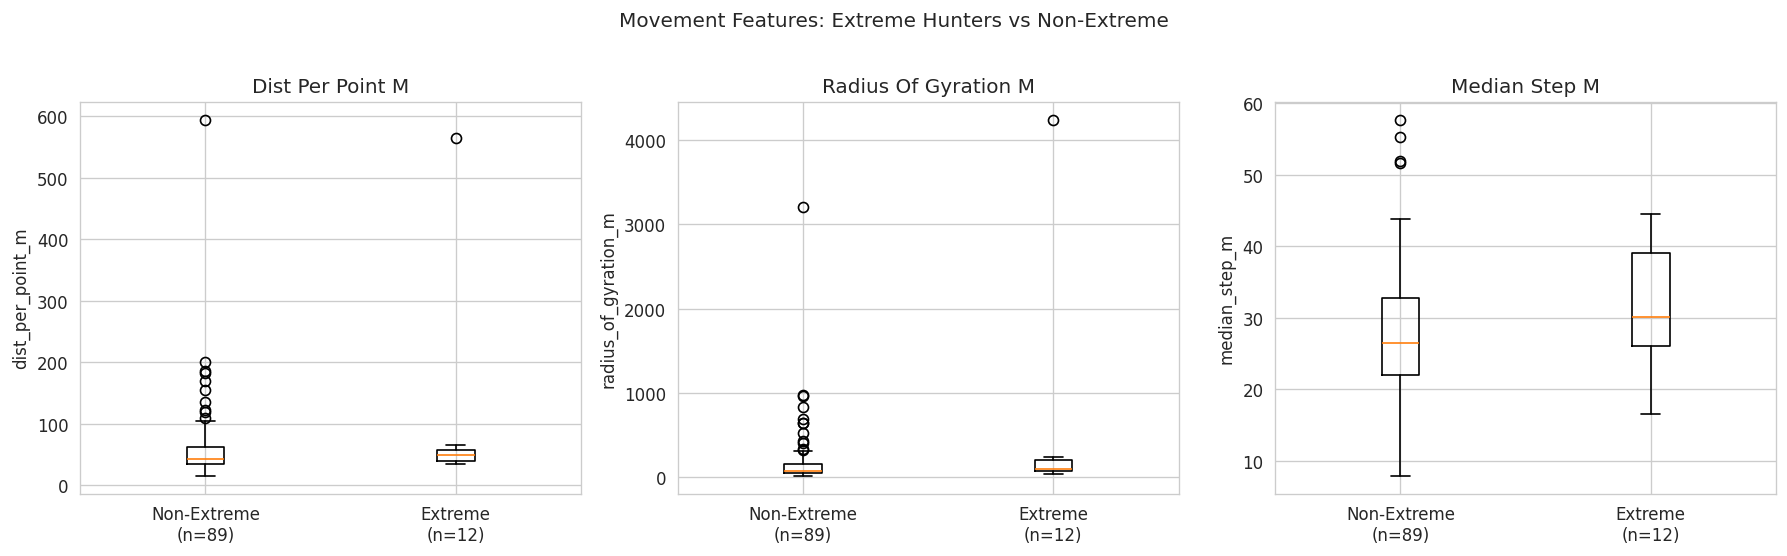

In [13]:
# Box plots comparing extreme vs non-extreme
compare_cols = ['dist_per_point_m', 'radius_of_gyration_m', 'median_step_m']
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for i, col in enumerate(compare_cols):
    data_ext = cat_features[cat_features['extreme_hunter'] == 1][col].dropna()
    data_non = cat_features[cat_features['extreme_hunter'] == 0][col].dropna()
    axes[i].boxplot(
        [data_non, data_ext],
        labels=['Non-Extreme\n(n={})'.format(len(data_non)),
                'Extreme\n(n={})'.format(len(data_ext))]
    )
    axes[i].set_ylabel(col)
    axes[i].set_title(col.replace('_', ' ').title())

plt.suptitle('Movement Features: Extreme Hunters vs Non-Extreme', y=1.02)
plt.tight_layout()
plt.savefig('fig_hunter_movement.png', dpi=150, bbox_inches='tight')
plt.show()

Extreme hunters do show higher displacement, but since the original data sample issue is still too small(n=12), which limits conclusion. Might have to try other ways in M4.

### Failed integration attempt: K-Prototypes with movement features on extreme hunters


In [19]:
# Demonstrate instability of K-Prototypes on n=12
from kmodes.kprototypes import KPrototypes

extreme_sub = cat_features[cat_features['extreme_hunter'] == 1].copy()
num_cols_hunt = ['dist_per_point_m', 'radius_of_gyration_m', 'median_step_m',
                 'hrs_indoors', 'age_years']
cat_cols_hunt = ['animal_sex']

# Drop rows with missing values
extreme_sub = extreme_sub.dropna(subset=num_cols_hunt + cat_cols_hunt)

if len(extreme_sub) >= 4:
    X_num_h = StandardScaler().fit_transform(extreme_sub[num_cols_hunt])
    X_cat_h = extreme_sub[cat_cols_hunt].values
    X_kp = np.hstack([X_num_h, X_cat_h])
    cat_idx = list(range(X_num_h.shape[1], X_kp.shape[1]))

    # Run with different random seeds to show instability
    print("K-Prototypes (k=2) on extreme hunters with movement features:")
    print(f"Sample size: {len(extreme_sub)}")
    print()
    for seed in [0, 1, 2, 42, 99]:
        kp = KPrototypes(n_clusters=2, init='Huang', random_state=seed, n_init=3)
        labs = kp.fit_predict(X_kp, categorical=cat_idx)
        sizes = sorted(pd.Series(labs).value_counts().values, reverse=True)
        print(f"  seed={seed:>2}: cluster sizes = {sizes}")

    print("\n-> Cluster assignments change with random seed.")
    print("   At n=12, this approach is unreliable.")
else:
    print(f"Only {len(extreme_sub)} cats with complete data — too few for clustering.")

K-Prototypes (k=2) on extreme hunters with movement features:
Sample size: 11

  seed= 0: cluster sizes = [np.int64(10), np.int64(1)]
  seed= 1: cluster sizes = [np.int64(9), np.int64(2)]
  seed= 2: cluster sizes = [np.int64(10), np.int64(1)]
  seed=42: cluster sizes = [np.int64(8), np.int64(3)]
  seed=99: cluster sizes = [np.int64(7), np.int64(4)]

-> Cluster assignments change with random seed.
   At n=12, this approach is unreliable.
